In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from skimage.draw import draw
from datetime import datetime
from scipy import interpolate
import scipy
import poppy

# PSD code
import h5py
import copy

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# declare MagAO-X variables
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'surf_off': True,
           'n_tests': 10}

wavelen = np.round(fr_parm['wavelength'].to(u.nm).value).astype(int)
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2:3}nm'.format(fr_parm['npix'], br, wavelen)

# load the CSV prescription values
home_dir = '/home/jhen/XWCL/code/MagAOX/' # change for exao0
data_dir = home_dir + 'data/'
rx_loc = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_allopd.csv'.format(parm_name)
rx_sys = mf.makeRxCSV(rx_loc, print_names=False)
n_folder = 10
n_filename = 11

# acquiring csv numerical values for specifically named optics
for t_optic, test_opt in enumerate(rx_sys):
    if test_opt['Name'] == 'pupil':
        entrance_radius = test_opt['Radius_m']*u.m
    if test_opt['Type'] == 'mirror' or test_opt['Type'] == 'DM': # remove surfaces
        rx_sys[t_optic][n_folder] = 'none' # file folder
        rx_sys[t_optic][n_filename] = 'none' # file name
    if test_opt['Name'] == 'vAPP-trans':
        vappTRANS_num = test_opt['Optical_Element_Number']
        vapp_diam = test_opt['Radius_m']*2*u.m
    if test_opt['Name'] == 'vAPP-opd':
        vappOPD_num = test_opt['Optical_Element_Number']

### Verifying the Pupil Patterns
4-f relays flip the pupil patterns around

Text(0.5, 1.0, 'M1 pupil (with bump)')

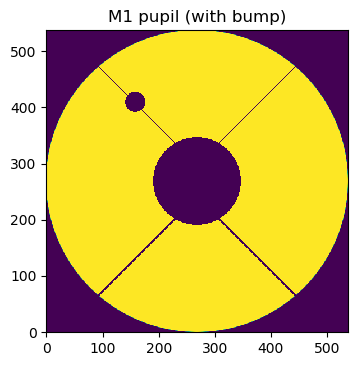

In [4]:
# check the pupil pattern first
m1_pupil = mf.mag_pupil_mask(samp=fr_parm['npix'], entrance_radius=3.25*u.m,
                             wavelength=632*u.nm, bump=True)
plt.figure(dpi=100)
plt.imshow(m1_pupil, origin='lower')
plt.title('M1 pupil (with bump)')

CPU times: user 16.5 s, sys: 4.54 s, total: 21.1 s
Wall time: 8.61 s


Text(0.5, 1.0, 'Woofer amplitude')

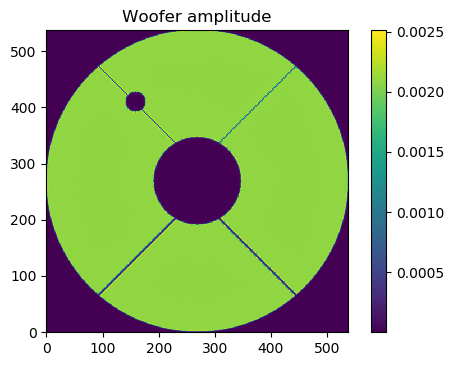

In [6]:
%%time
# woofer plane analysis
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='Woofer', bump=True)

wfr_psf, wfr_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

wfr_amp = poppy.utils.pad_or_crop_to_shape(wfr_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(wfr_amp, origin='lower')
plt.colorbar()
plt.title('Woofer amplitude')

CPU times: user 24.8 s, sys: 5.95 s, total: 30.7 s
Wall time: 12.5 s


Text(0.5, 1.0, 'tweeter amplitude')

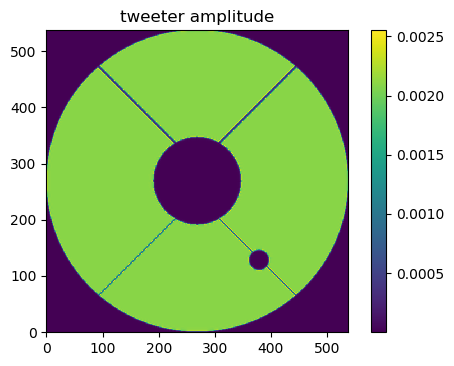

In [7]:
%%time
# tweeter plane analysis
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='Tweeter', bump=True)
tw_psf, tw_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

tw_amp = poppy.utils.pad_or_crop_to_shape(tw_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(tw_amp, origin='lower')
plt.colorbar()
plt.title('tweeter amplitude')

CPU times: user 40.1 s, sys: 9.32 s, total: 49.4 s
Wall time: 20.1 s


Text(0.5, 1.0, 'vAPP amplitude')

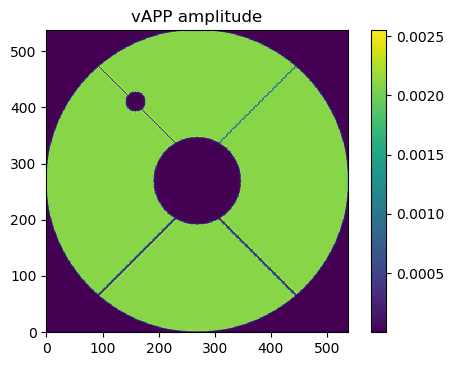

In [8]:
%%time
# vAPP plane analysis
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='vAPP-trans', bump=True)
vapp_psf, vapp_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

vapp_amp = poppy.utils.pad_or_crop_to_shape(vapp_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(vapp_amp, origin='lower')
plt.colorbar()
plt.title('vAPP amplitude')

CPU times: user 52.1 s, sys: 10.5 s, total: 1min 2s
Wall time: 24.8 s


Text(0.5, 1.0, 'Lyot amplitude')

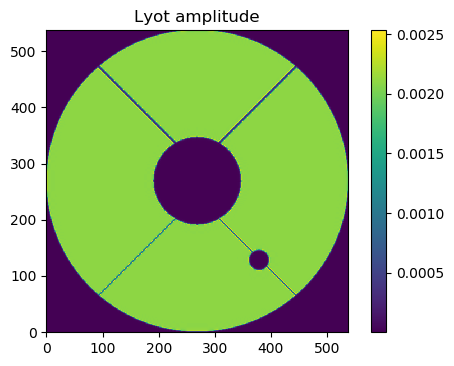

In [9]:
%%time
# vAPP plane analysis
rx_sys['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_sys['surf_PSD_filename'][vappOPD_num] = 'none'
magaox = mf.csvFresnel(rx_csv=rx_sys, samp=fr_parm['npix'], oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, break_plane='LyotPlane', bump=True)
ly_psf, ly_wf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value, return_final=True)

ly_amp = poppy.utils.pad_or_crop_to_shape(ly_wf[0].amplitude, (fr_parm['npix'], fr_parm['npix']))
plt.figure(dpi=100)
plt.imshow(ly_amp, origin='lower')
plt.colorbar()
plt.title('Lyot amplitude')

### Set the amplitude masks

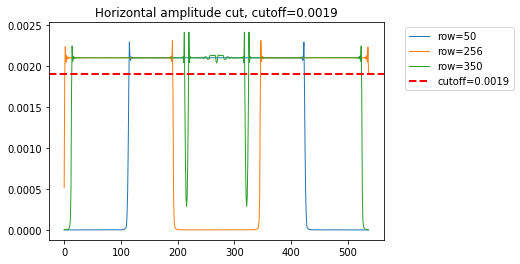

In [10]:
amp_cutoff = 0.0019
row_set = [50, 256, 350]
for j in range(0, len(row_set)):
    plt.plot(tw_amp[row_set[j]], linewidth=1, label='row={0}'.format(row_set[j]))
plt.axhline(y=amp_cutoff, color='r', linestyle='--', 
            linewidth=2, label='cutoff={0}'.format(amp_cutoff))
plt.title('Horizontal amplitude cut, cutoff={0}'.format(amp_cutoff))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',)

Text(0.5, 1.0, 'Tweeter mask, amplitude mask cutoff=0.0019')

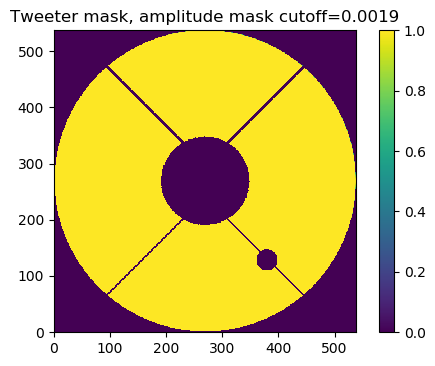

In [11]:
pupil_mask = np.flipud(np.fliplr(m1_pupil))
tw_amp_mask = (tw_amp > amp_cutoff) * 1.0 * pupil_mask
plt.figure(dpi=100)
plt.imshow(tw_amp_mask, origin='lower')
plt.colorbar()
plt.title('Tweeter mask, amplitude mask cutoff={0}'.format(amp_cutoff))

Text(0.5, 1.0, 'Lyot mask, amplitude mask cutoff=0.0019')

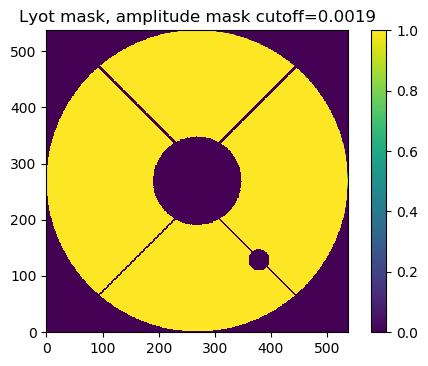

In [14]:
ly_amp_mask = (ly_amp > amp_cutoff) * 1.0 * pupil_mask 
ly_amp_mask *= tw_amp_mask # combine both masks together
plt.figure(dpi=100)
plt.imshow(ly_amp_mask, origin='lower')
plt.colorbar()
plt.title('Lyot mask, amplitude mask cutoff={0}'.format(amp_cutoff))

In [15]:
# masks comparison
mask_diff = np.abs(tw_amp_mask.astype(int) - ly_amp_mask.astype(int))
np.sum(mask_diff)

0

### Save the mask file
Choose Lyot because there's 6 less active pixels than Tweeter

In [16]:
hdr = fits.Header()
hdr['pixscale'] = (ly_wf[0]._pixelscale_m.value, 
                   "pixelscale at pupil plane, [{0}]".format(ly_wf[0]._pixelscale_m.unit))
hdr['oversamp'] = (ly_wf[0].oversample,
                   "oversample value for Fresnel propagation")
fits.writeto('lyot_tweeter_amp_mask_bump_{0}.fits'.format(fr_parm['npix']), 
             ly_amp_mask.astype(int), hdr, overwrite=True)

### Check with Tweeter opd wfe map

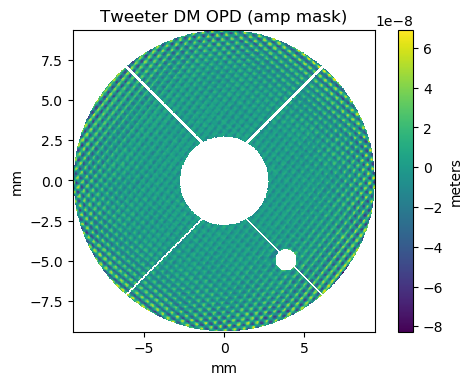

In [17]:
# check with the tweeter opd map
tw_fits = fits.open(home_dir+'data/wfemap/tweeter_meters_opd_{0}.fits'.format(fr_parm['npix']))[0]
tw_wfe = tw_fits.data
tw_hdr = tw_fits.header

dfx.show_image(data=dfx.sn_map(tw_wfe, ly_amp_mask),
               data_unit='meters',
               pixscale=(tw_wf[0]._pixelscale_m*u.pix).to(u.mm),
               fig_title='Tweeter DM OPD (amp mask)')

In [20]:
# calculate the rms
active_tw = tw_wfe[ly_amp_mask==1]*np.cos(11.716*u.deg)
np.sqrt(np.mean(np.square(active_tw*0.5)))

<Quantity 7.35005607e-09>